# Семинар 1: знакомство с PyTorch 🔥

## Вступление

В этом семинаре мы познакомимся с библиотекой **PyTorch**. Он очень похож на **NumPy**, с одним лишь отличием (на самом деле их больше, но сейчас мы поговорим про самое главное) — **PyTorch** может считать градиенты за вас. Таким образом вам не надо будет руками писать обратный проход в нейросетях.

**План семинара**

1. Вспоминаем **NumPy** и сравниваем операции его функциональность с **PyTorch**
2. Создаем тензоры в **PyTorch** и изучаем больше базовых операций
3. Работаем с градиентами руками
4. Моя первая нейросеть

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from tqdm.notebook import tqdm

%matplotlib inline

### 1. Вспоминаем **NumPy** и сравниваем операции его функциональность с **PyTorch**

Мы можем создавать матрицы, перемножать их, складывать, транспонировать и в целом совершать любые матричные операции

In [ ]:
# случайная матрица
a = np.random.rand(5, 3)
a

In [ ]:
# размеры массива
a.shape

In [ ]:
# сложение
a + 5

In [ ]:
# матричное умножение
a @ a.T

In [ ]:
# среднее по колонкам
a.mean(axis=-1)

In [ ]:
# решейп
a.reshape(3, 5).shape

**Разминка**

При помощи **NumPy** посчитайте сумму квадратов натуральных чисел от 1 до 10000.

In [ ]:
# YOUR CODE

Аналогичные операции в **PyTorch** очень похожи, но иногда имеют немного другой синтаксис

In [ ]:
# случайный тензор
x = torch.rand(5, 3)
x

In [ ]:
# размеры тензора
x.shape

In [ ]:
# тоже размеры тензора
x.size()

In [ ]:
# сложение
x + 5

In [ ]:
# матричное умножение
# читайте документации по различным вариантам: @, torch.mm, torch.matmul, torch.bmm
torch.matmul(x, x.transpose(1, 0))

In [ ]:
# очередное матричное умножение
x.mm(x.t())

In [ ]:
# поэлементное умножение
x * x

In [ ]:
# среднее по колонкам
x.mean(dim=-1)

In [ ]:
# решейп
x.view([3, 5]).shape

In [ ]:
# или так
x.reshape([3, 5]).shape

In [ ]:
# будьте внимательны и не используйте view для транспонирования осей!
x.view_as(x.t()) == x.t()

Небольшой пример того, как меняются операции:

* `x.reshape([1,2,8]) -> x.view(1,2,8)`

* `x.sum(axis=-1) -> x.sum(dim=-1)`

* `x.astype("int64") -> x.type(torch.LongTensor)`

Для помощи вам есть [таблица](https://github.com/torch/torch7/wiki/Torch-for-Numpy-users), которая поможет вам найти аналог **NumPy** операции в **PyTorch**


Разминка на PyTorch

При помощи pytorch посчитайте сумму квадратов натуральных чисел от 1 до 10000.

In [ ]:
# YOUR CODE

### 2. Создаем тензоры в **PyTorch** и изучаем больше базовых операций

In [ ]:
# пустой тензор
x = torch.empty(5, 3)
x

In [ ]:
# случайный тензор ~ Uniform[0, 1)
x = torch.rand(5, 3)
x

In [ ]:
# тензор с нулями и указанием типов чисел
x = torch.zeros(5, 3, dtype=torch.float32)
x

In [ ]:
# конструируем тензор из питоновского листа
x = torch.tensor([5.5, 3])
x

In [ ]:
# используем уже созданный тензор для создания тензора из единичек
x1 = x.new_ones(5, 3, dtype=torch.double)
x1

In [ ]:
# создаем случайный тензор с размерами другого тензора
x = torch.randn_like(x1, dtype=torch.float)
x

In [ ]:
x = torch.rand(5, 3)
y = torch.rand(5, 3)

In [ ]:
x

In [ ]:
y

In [ ]:
# сложение
x + y

In [ ]:
# очередное сложение
z = torch.add(x, y)
z

In [ ]:
# наконец, ещё одно сложение!
torch.add(x, y, out=x)
x

In [ ]:
# добавили измерение в начало, аналог броадкастинга
x.unsqueeze(0).size()

In [ ]:
# убрали одно единичное измерение
x.unsqueeze(0).unsqueeze(1).squeeze(0).size()

In [ ]:
# убрали все единичные измерения
x.unsqueeze(0).unsqueeze(1).squeeze().size()

In [ ]:
# операции без _ не меняют тензор, а создают копию
x.unsqueeze(0)
x.size()

In [ ]:
# операции с _ меняют тензор
x.unsqueeze_(0)
x.size()

Мы можем делать обычные срезы и переводить матрицы из **PyTorch** в **NumPy** и наоборот:

In [ ]:
a = np.ones((3, 5))
x = torch.ones((3, 5))
np.allclose(x.numpy(), a)

In [ ]:
np.allclose(x.numpy()[:, 1], a[:, 1])

In [ ]:
torch.from_numpy(x.numpy())

### 3. Работаем с градиентами руками

In [ ]:
# скачиваем The Boston Housing Dataset
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [ ]:
plt.scatter(data[:, -1], target);

В **PyTorch** есть возможность при создании тензора указывать нужно ли считать по нему градиент или нет, с помощью параметра `requires_grad`. Когда `requires_grad=True` мы сообщаем фреймворку, о том, что мы хотим следить за всеми тензорами, которые получаются из созданного. Иными словами, у любого тензора, у которого указан данный параметр, будет доступ к цепочке операций и преобразований совершенными с ними. Если эти функции дифференцируемые, то у тензора появляется параметр `.grad`, в котором хранится значение градиента.

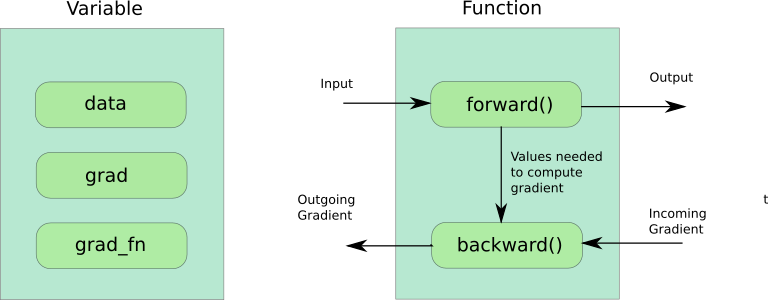

Если к результирующему тензору применить метод `.backward()`, то фреймворк посчитает по цепочке градиенты для всех тензоров, у которых `requires_grad=True`.

In [ ]:
w = torch.rand(1, requires_grad=True)
b = torch.rand(1, requires_grad=True)

x = torch.tensor(data[:, -1] / data[:, -1].max(), dtype=torch.float32)
y = torch.tensor(target, dtype=torch.float32)

# только создали тензоры и в них нет градиентов
assert w.grad is None
assert b.grad is None

In [ ]:
x.size(), y.size()

In [ ]:
y_pred = w * x + b
loss = torch.mean((y_pred - y) ** 2)
loss.backward()

In [ ]:
# сделали операции и посчитали градиенты, появилось значение соответствующих полей
assert w.grad is not None
assert b.grad is not None

print(f"dL/dw = {w.grad}")
print(f"dL/db = {b.grad}")

Для доступа к значениям в тензоре используйте атрибут `.data`:

In [ ]:
w.data, w.grad

In [ ]:
w

In [ ]:
from IPython.display import clear_output

for i in range(300):
    y_pred = w * x + b
    # попробуйте сделать полиномиальную регрессию в данном предсказании и посчитать градиенты после
    loss = torch.mean((y_pred - y) ** 2)
    loss.backward()

    # делаем шаг градиентного спуска с lr = .05
    w.data -= 0.05 * w.grad
    b.data -= 0.05 * b.grad

    # обнуляем градиенты, чтобы на следующем шаге опять посчитать и не аккумулировать их
    w.grad.data.zero_()
    b.grad.data.zero_()

    # рисуем картинки
    if (i + 1) % 5 == 0:
        clear_output(True)
        plt.figure(figsize=(10, 8))
        plt.scatter(x.data.numpy(), y.data.numpy(), label="data")
        plt.scatter(
            x.data.numpy(),
            y_pred.data.numpy(),
            color="orange",
            linewidth=5,
            label="predictions",
        )
        plt.xlabel("LSTAT", fontsize=14)
        plt.ylabel("MEDV (target)", fontsize=14)
        plt.title("Boston modelling", fontsize=18)
        plt.legend(fontsize=14)
        plt.show()

        print("loss = ", loss.data.numpy())
        if loss.data.numpy() < 0.1:
            print("Done!")
            break

### 4. Моя первая нейросеть

Для того, чтобы разобраться как обучать нейросети в **PyTorch**, нужно освоить три вещи:

1. Как формировать батчи и подавать их на вход сети
2. Как задать архитектуру сети
3. Как написать цикл обучения и отслеживать метрики

#### Как формировать батчи и подавать их на вход нейросети

Чтобы иметь возможность итерироваться по данным и применять к ним преобразования (например, аугментации, о которых вы узнаете позже), нужно создать свой класс унаследованный от `torch.utils.data.Dataset`.

У такого класса **должно быть** три метода:

* `__init__` — создаёт поля класса (например, путь к папке с файлами с тренировочными объектами)
* `__len__` — возвращает информацию о том, сколько объектов у нас в датасете
* `__getitem__` — по индексу возвращает семпл и таргет к нему


Давайте напишем такой сами, в качестве данных используя рандомные значения.

In [ ]:
class RandomDataset(torch.utils.data.Dataset):
    """
    Our random dataset
    """

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return {
            "sample": torch.tensor(self.x[idx, :], dtype=torch.float),
            "target": self.y[idx],
        }

In [ ]:
x = np.random.rand(1000, 5)
y = np.random.rand(1000)

In [ ]:
our_dataset = RandomDataset(x, y)

In [ ]:
our_dataset.__getitem__(1)

Для того, чтобы из данных получать батчи в pytorch используется такая сущность как даталоадер, который принимает на вход класс унаследованный от `torch.utils.data.Dataset`. Сейчас посмотрим на пример:

In [ ]:
dataloader = torch.utils.data.DataLoader(our_dataset, batch_size=4)

Работают с ним следующим образом:

In [ ]:
batch = next(iter(dataloader))

print(f"Sample:\n{batch['sample']}")
print(f"Target:\n{batch['target']}")

**Как сделать нейросеть**

Для того, чтобы в high-level **PyTorch** создавать нейросети, используется модуль `torch.nn`. Нейросеть должна быть унаследована от класса `nn.Module`. Пример как это может выглядеть:

```
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.conv2 = nn.Conv2d(20, 20, 5)

    def forward(self, x):
       x = F.relu(self.conv1(x))
       return F.relu(self.conv2(x))
```

Как мы видим на данном примере, у данного класса **должен быть** метод `forward`, который определяет прямой проход нейросети. Также из класса выше видно, что модуль `nn` содержит в себе реализацию большинства слоев, а модуль `nn.functional` -- функций активаций.

Есть еще один способ создать нейросеть и давайте его разберем на практике:

In [ ]:
model = nn.Sequential()  # создаем пустую модель, в которую будем добавлять слои
model.add_module(
    "l1", nn.Linear(5, 30)
)  # добавили слой с 5-ю нейронами на вход и 3-мя на выход
model.add_module("l2", nn.ReLU())  # добавили функцию активации
model.add_module(
    "l3", nn.Linear(30, 1)
)  # добавили слой с 3-мя нейронами на вход и 5-ю на выход

# альтернативный способ
another_model = nn.Sequential(nn.Linear(5, 30), nn.ReLU(), nn.Linear(30, 1))

In [ ]:
y_pred = model(batch["sample"])  # получили предсказания модели

**Как написать цикл обучения и отслеживать метрики**

Давайте теперь соберем теперь загрузку данных, создание модели и обучим на уже созданном для нас датасете MNIST

In [ ]:
# используем готовый класс от торча для загрузки данных для тренировки
mnist_train = torchvision.datasets.MNIST(
    "./mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor()
)
mnist_val = torchvision.datasets.MNIST(
    "./mnist/", train=False, download=True, transform=torchvision.transforms.ToTensor()
)

# так как это уже унаследованный от Dataset класс, его можно сразу обернуть в даталоадер
train_dataloader = torch.utils.data.DataLoader(
    mnist_train, batch_size=4, shuffle=True, num_workers=1
)

val_dataloader = torch.utils.data.DataLoader(
    mnist_val, batch_size=4, shuffle=False, num_workers=1
)

In [ ]:
# посмотрим на то, с чем мы работаем
for i in [0, 1]:
    plt.subplot(1, 2, i + 1)
    plt.imshow(mnist_train[i][0].squeeze(0).numpy().reshape([28, 28]))
    plt.title(str(mnist_train[i][1]))
plt.show()

In [ ]:
model = nn.Sequential(
    nn.Flatten(),  # превращаем картинку 28х28 в вектор размером 784
    nn.Linear(
        28 * 28, 128
    ),  # линейный слой, преобразующий вектор размера 784 в вектор размера 128
    nn.ReLU(),  # нелинейность
    nn.Linear(
        128, 10
    ),  # линейный слой, преобразующий вектор размера 128 в вектор размера 10
)

# создаем оптимизатор, который будет обновлять веса модели
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

Веса моделей хранятся в виде матриц и выглядят так:

In [ ]:
[x for x in model.named_parameters()]

Вместо того, чтобы каждый раз самим рисовать графики в `matplotlib`, мы будем _красиво_ трекать метрики в полуавтоматическом режиме в [wandb](https://wandb.ai). Для этого регистрируемся на сайте, устанавливаем и логинимся (это того стоит).

Note. Помимо этого инструмента есть другие альтернативы: Tensorboard (очень минималистичный, работает локально), MLFlow (менее красивый, но опенсорсный), Neptune (примерно как W&B).

In [ ]:
!pip install wandb --upgrade --quiet

In [ ]:
import wandb

In [ ]:
# логинимся в своего пользователя (предварительно нужно ввести ключ из настроек с wandb.ai через консоль)
!wandb login
#wandb.login()

In [ ]:
# инициализируем проект
wandb.init(project="pytorch-demo")
# сохраняем параметры сетки в wandb + просим следить за градиентами сетки
wandb.watch(model);

Можно перейти по ссылке и следить за нашей моделью прямо во время обучения!

Одним из основных преимуществ PyTorch является возможность использования GPU-ускорителей на CUDA-совместимых графических процессорах Nvidia Compute Unified Device Architecture (CUDA) и Apple Metal Performance Shaders (MPS). До сих пор все, что мы делали, было на процессоре.

Во-первых, мы должны проверить, доступен ли графический процессор, с помощью метода ```is_available()```. Если у вас не установлен CUDA-совместимый графический процессор и драйверы CUDA, то после исполнения ячейки ниже в качестве девайса будет выступать CPU.

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Как только мы определили, что один или несколько графических процессоров доступны, нам нужно поместить наши данные туда, где графический процессор сможет их увидеть. Ваш процессор выполняет вычисления над данными в оперативной памяти вашего компьютера. К вашему графическому процессору подключена выделенная память. Всякий раз, когда вы хотите выполнить вычисление на устройстве, вы должны переместить все данные, необходимые для этого вычисления, в память, доступную этому устройству.

По умолчанию новые тензоры создаются на CPU, поэтому нам нужно указать, когда мы хотим создать наш тензор на графическом процессоре, с помощью необязательного аргумента устройства.

In [ ]:
x = torch.rand(2, 2, device=device)
x

Чтобы выполнять вычисления с использованием двух или более тензоров, все тензоры должны находиться на одном устройстве.

Если у вас уже есть тензор, расположенный на одном устройстве, вы можете переместить его на другое с помощью метода ```to()```.
Перенесем созданную ранее модель на наш новый девайс.

In [ ]:
model.to(device)

In [ ]:
# всего у нас будет 5 эпох (5 раз подряд пройдемся по всем батчам из трейна)
for epoch in range(5):
    for x_train, y_train in tqdm(train_dataloader):  # берем батч из трейн лоадера
        y_pred = model(x_train.to(device))  # делаем предсказания
        loss = F.cross_entropy(y_pred, y_train.to(device))  # считаем лосс
        loss.backward()  # считаем градиенты обратным проходом
        optimizer.step()  # обновляем параметры сети
        optimizer.zero_grad()  # обнуляем посчитанные градиенты параметров

    if epoch % 2 == 0:
        val_loss = []  # сюда будем складывать **средний по бачу** лосс
        val_accuracy = []
        with torch.no_grad():  # на валидации запрещаем фреймворку считать градиенты по параметрам
            for x_val, y_val in tqdm(
                val_dataloader
            ):  # берем батч из валидационного лоадера
                y_pred = model(x_val.to(device))  # делаем предсказания
                loss = F.cross_entropy(y_pred, y_val.to(device))  # считаем лосс
                val_loss.append(loss.cpu().numpy())  # добавляем в массив
                val_accuracy.extend(
                    (torch.argmax(y_pred, dim=-1) == y_val.to(device)).cpu().numpy().tolist()
                )

        # скидываем метрики на wandb и автоматом смотрим на графики
        wandb.log(
            {
                "mean val loss": np.mean(val_loss),
                "mean val accuracy": np.mean(val_accuracy),
            }
        )

        # печатаем метрики
        print(
            f"Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}"
        )

### Дополнительные материалы

* [Хорошая книга про pytorch](https://isip.piconepress.com/courses/temple/ece_4822/resources/books/Deep-Learning-with-PyTorch.pdf)
* [Использование pytorch на GPU](https://pytorch.org/docs/master/notes/cuda.html)
* [Pytorch за 60 минут](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* [Как устроено автоматическое дифференцирование в pytorch](http://videolectures.net/site/normal_dl/tag=1129745/deeplearning2017_johnson_automatic_differentiation_01.pdf)